# Clustering

In this notebook we consider two different implementations of the ToMAto clustering algorithm first proposed by [Steve Oudot](https://geometrica.saclay.inria.fr/data/Steve.Oudot/clustering/.) 

One implementation relies on the implementations of [tomaster](https://pypi.org/project/tomaster/#description) as well as [GUDHI](https://gudhi.inria.fr/python/latest/clustering.html)

While the settings in tomaster allow to reliably have good clustering results for persistence-based parameters, namely 0D entropy as well as L2-norm of the Betti Curve, the conventional parameters show a worse clustering result. 
Furthermore, we need to specify the number of clusters which we want to have in the analysis. 

For Gudhi, persistence-based parameters can find the 6 clusters without any kind of special setting of the hyperparameters. Conventional parameters fail completely, and most of the times do not even recover 6 clusters when we set **n_cluster=6**.

Obviously, the results depend on the postprocessing of the surface; but it's the main results stay the same.

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from tomaster import tomato as tm_tomato

from gudhi.clustering.tomato import Tomato as gd_tomato
from sklearn import preprocessing

from sklearn.metrics import accuracy_score

# from sklearn.metrics import rand_score, adjusted_rand_score,\
#     mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score

# import path variables
from src.config import data_path_processed, figures_path
# import simulation parameters
from src.config import simulation_parameters

from src.auxiliary import savefig_severalformats, check_load_file

In [26]:
# load the data and set the hyper parameters
processed = simulation_parameters['simulation_processed']
file_appendix = simulation_parameters["calculation_method"]

fn = f'numSimulation_parameters_{simulation_parameters["calculation_method"]}.csv'
df_params = check_load_file(data_path_processed / fn)  
  
  
## pick the type of surface heights to consider
df_params = df_params[df_params['processed'] == processed]
df_params = df_params.reset_index(drop=True)

le = LabelEncoder()
y = le.fit_transform(df_params['coverage'].values)
df_params['coverage_labels'] = y


# Tomaster CLustering

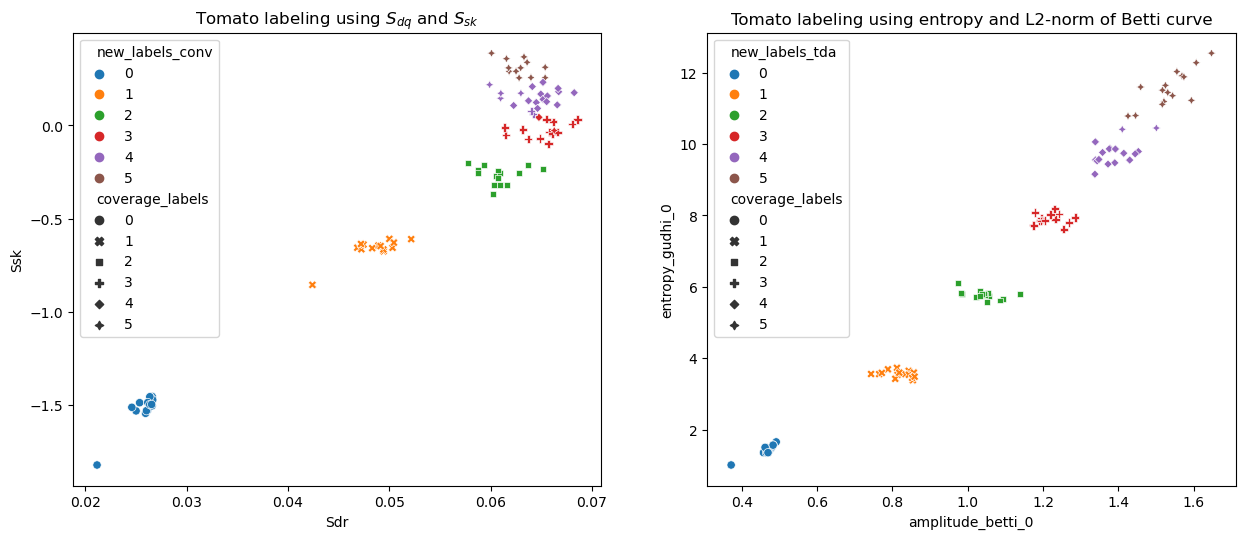

In [27]:
col_pair = ['Sdr', 'Ssk']
df_plot = df_params.copy(deep=True)

X = df_params[col_pair].values
clusters_conv = tm_tomato(points=X, k=7, n_clusters=6)
df_plot['new_labels_conv'] = clusters_conv

col_pair_tda = ['amplitude_betti_0', 'entropy_gudhi_0']
X = df_params[col_pair_tda].values
clusters_tda = tm_tomato(points=X, k=7, n_clusters=6)
df_plot['new_labels_tda'] = clusters_tda

fig, ax = plt.subplots(1,2, dpi=100, figsize=(15,6))
axi = (0)
sns.scatterplot(data=df_plot,
                y=col_pair[1], 
                x=col_pair[0],
                hue='new_labels_conv', 
                palette='tab10',
                style='coverage_labels',
                ax=ax[axi])
ax[axi].set_title('Tomato labeling using $S_{dq}$ and $S_{sk}$');

axi = (1)
sns.scatterplot(data=df_plot,
                y=col_pair_tda[1], 
                x=col_pair_tda[0],
                hue='new_labels_tda', 
                palette='tab10',
                style='coverage_labels',
                ax=ax[axi])
ax[axi].set_title('Tomato labeling using entropy and L2-norm of Betti curve');

Conv, number of misslabelled samples: 11
TDA , number of misslabelled samples: 2


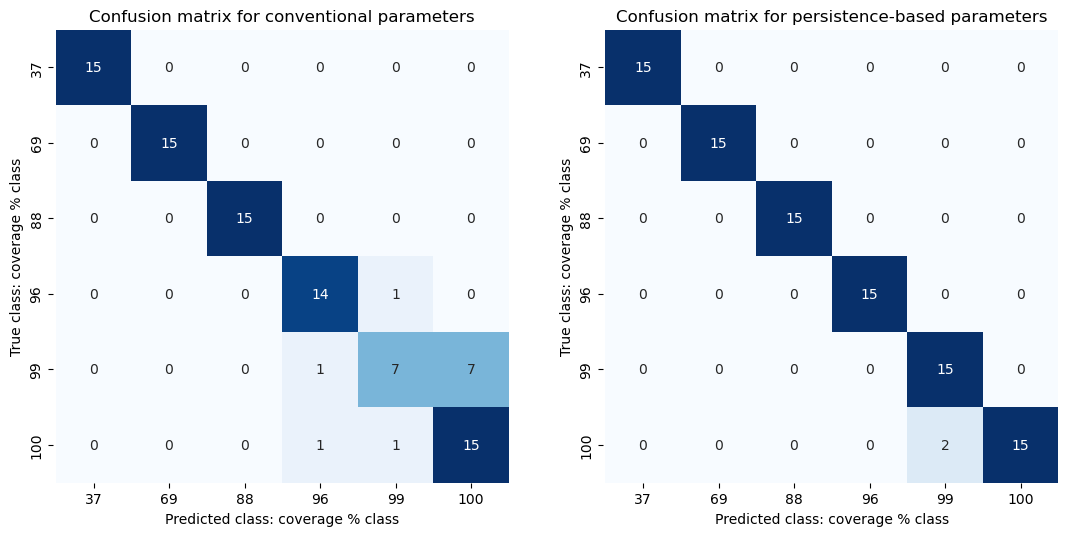

In [28]:
k = 5
kconv = 5
ktda = 7

col_pair = ['Sdr', 'Ssk']
df_plot = df_params

X = df_params[col_pair].values
# using gudhi tomato, we do not need to specify n_clusters=6
clusters_conv = tm_tomato(points=X, k=kconv, n_clusters=6) 
df_plot['new_labels_conv'] = clusters_conv

col_pair_tda = ['amplitude_betti_0', 'entropy_gudhi_0']
X = df_params[col_pair_tda].values
# using gudhi tomato, we do not need to specify n_clusters=6
# for tomaster we do.
clusters_tda = tm_tomato(points=X, k=ktda, n_clusters=6) 
df_plot['new_labels_tda'] = clusters_tda

fig, ax = plt.subplots(1,2, dpi=100, figsize=(13,6))
axi = (0)
cf_matrix = confusion_matrix(le.inverse_transform(y),
                             le.inverse_transform(clusters_conv))
print('Conv, number of misslabelled samples:', 
      np.sum(np.abs(np.triu(cf_matrix) - np.tril(cf_matrix))))

sns.heatmap(cf_matrix,#/np.sum(cf_matrix), 
            annot=True,
            # fmt='.2%', 
            cmap='Blues',
            ax=ax[axi],
            xticklabels=np.unique(df_params['coverage']),
            yticklabels=np.unique(df_params['coverage']),
            cbar=False)
ax[axi].set_title('Confusion matrix for conventional parameters')
ax[axi].axis('equal')
ax[axi].set_ylabel('True class: coverage %'+' class')
ax[axi].set_xlabel('Predicted class: coverage %'+' class')

axi = (1)
cf_matrix = confusion_matrix(le.inverse_transform(y),
                             le.inverse_transform(clusters_tda))
print('TDA , number of misslabelled samples:', 
      np.sum(np.abs(np.triu(cf_matrix) - np.tril(cf_matrix))))

sns.heatmap(cf_matrix,#/np.sum(cf_matrix), 
            annot=True,
            # fmt='.2%', 
            cmap='Blues',
            ax=ax[axi],
            xticklabels=np.unique(df_params['coverage']),
            yticklabels=np.unique(df_params['coverage']),
            cbar=False)
ax[axi].set_title('Confusion matrix for persistence-based parameters')
ax[axi].axis('equal')
ax[axi].set_ylabel('True class: coverage %'+' class')
ax[axi].set_xlabel('Predicted class: coverage %'+' class')


savefig_severalformats(fig, f'tomato_tomaster_confusionmatrix_{file_appendix}',
                       figures_path)

# GUDHI CLUSTERING

While the gudhi implementation is better in terms of automatically finding the right number of clusters (for the case of TDA). 

It fails for conventional parameters; picking the right cluster labels might not work due to similar sizes.

In [46]:
# Encode the coverage groups as 0, ..., 5
le = preprocessing.LabelEncoder()
df_params['coverage_labels'] = le.fit_transform(df_params['coverage'].values)

conv_par = 'Sdr'
tda_par = 'amplitude_betti_0'

df_plot = df_params.copy(deep=True)

tom = gd_tomato(n_clusters=6, k=6)
tom.fit(df_params.loc[:,[conv_par, 'Ssk']].values)
df_plot['new_labels_conv'] = tom.labels_

tom2 = gd_tomato()
tom2.fit(df_params.loc[:,['entropy_gudhi_0', tda_par]].values)
df_plot['new_labels_tda'] = tom2.labels_

col_pair = ['Sdr', 'Ssk']
col_pair_tda = ['entropy_gudhi_0', 'amplitude_betti_0']

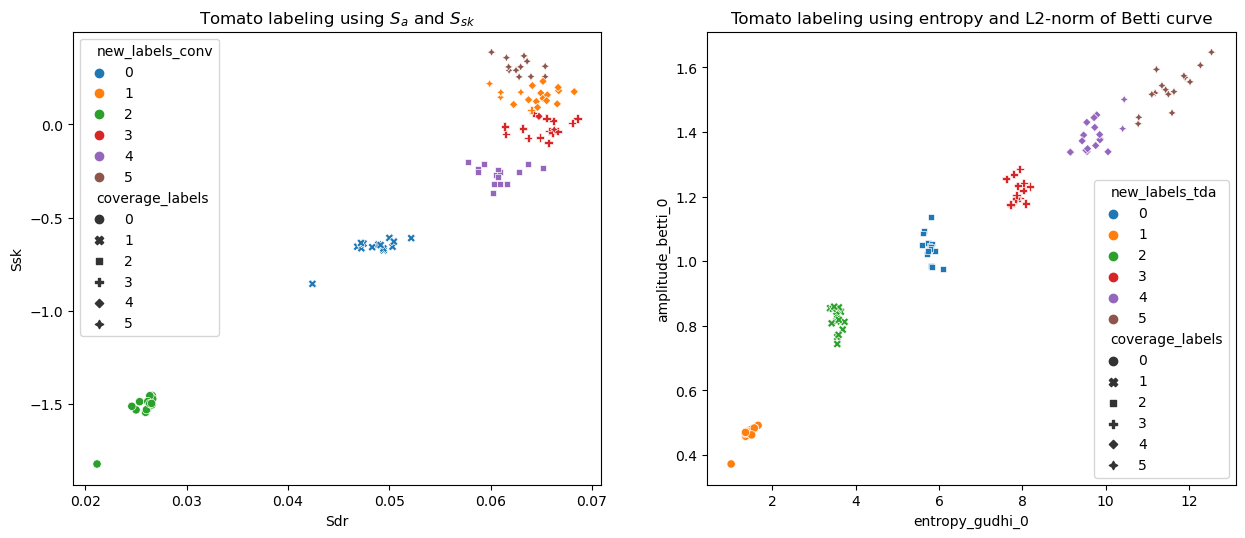

In [47]:
fig, ax = plt.subplots(1,2, dpi=100, figsize=(15,6))
axi = (0)
sns.scatterplot(data=df_plot,
                y=col_pair[1], 
                x=col_pair[0],
                hue='new_labels_conv', 
                palette='tab10',
                style='coverage_labels',
                ax=ax[axi])
ax[axi].set_title('Tomato labeling using $S_a$ and $S_{sk}$');

axi = (1)
sns.scatterplot(data=df_plot,
                y=col_pair_tda[1], 
                x=col_pair_tda[0],
                hue='new_labels_tda', 
                palette='tab10',
                style='coverage_labels',
                ax=ax[axi])
ax[axi].set_title('Tomato labeling using entropy and L2-norm of Betti curve');

In [48]:
print('How many clusters are automatically detected:')
print(len(np.unique(df_plot['new_labels_conv'])), len(np.unique(df_plot['new_labels_tda'])))

df_tmp = df_plot[['coverage', 'coverage_labels', 'new_labels_tda', 'new_labels_conv']].set_index('coverage_labels')

replace_conv = False

tda_replace = []
conv_replace = []
for i in np.unique(df_plot['coverage_labels']):
    tda_replace.append(df_tmp.loc[i, 'new_labels_tda'].mode().values[0])
    conv_replace.append(df_tmp.loc[i, 'new_labels_conv'].mode().values[0])

if len(np.unique(tda_replace)) != len(np.unique(df_plot['coverage_labels'])):
    print(f'ERROR tda')
    print(tda_replace)
else:
    tda_replace = {tda_replace[i]:i for i in range(len(np.unique(df_plot['coverage_labels'])))}
    df_plot['new_labels_tda'] = df_plot['new_labels_tda'].replace(tda_replace)
    
if len(np.unique(conv_replace)) != len(np.unique(df_plot['coverage_labels'])):
    print('ERROR conv ')
    print(conv_replace)
    replace_conv = True
else:
    conv_replace = {conv_replace[i]: i for i in range(len(np.unique(df_plot['coverage_labels'])))}
    df_plot['new_labels_conv'] = df_plot['new_labels_conv'].replace(conv_replace)


How many clusters are automatically detected:
6 6


In [49]:
if replace_conv:
    perfect_matches = {}
    to_be_assigned = []
    for cov_lab in np.unique(df_plot['coverage_labels']):
        val = df_plot.loc[df_plot['coverage_labels']==cov_lab, 'new_labels_conv']
        if len(val.value_counts()) == 1:
            perfect_matches[val.iloc[0]] = cov_lab
        else:
            to_be_assigned.append(cov_lab)

    val_to_be_assigned = [i for i in np.unique(df_plot['coverage_labels']) 
                        if i not in list(perfect_matches.keys())]

    print('Not perfect matchings are:', val_to_be_assigned, to_be_assigned)

    # now consider all the matching for the non-perfect ones
    from itertools import permutations

    accuracy_list = []
    matches_list = []
    for x in permutations([0,1,2], 3):
        matches = perfect_matches.copy()
        for i, conv_lab in enumerate(to_be_assigned):
            matches[x[i]] = conv_lab 
        accuracy_list.append(accuracy_score(df_plot['coverage_labels'].values,
                            df_plot['new_labels_conv'].replace(matches).values))
        matches_list.append(matches)

    # get the match with the best accuracy
    conv_replace = matches_list[np.argmax(accuracy_list)]
    df_plot['new_labels_conv'] = df_plot['new_labels_conv'].replace(conv_replace)


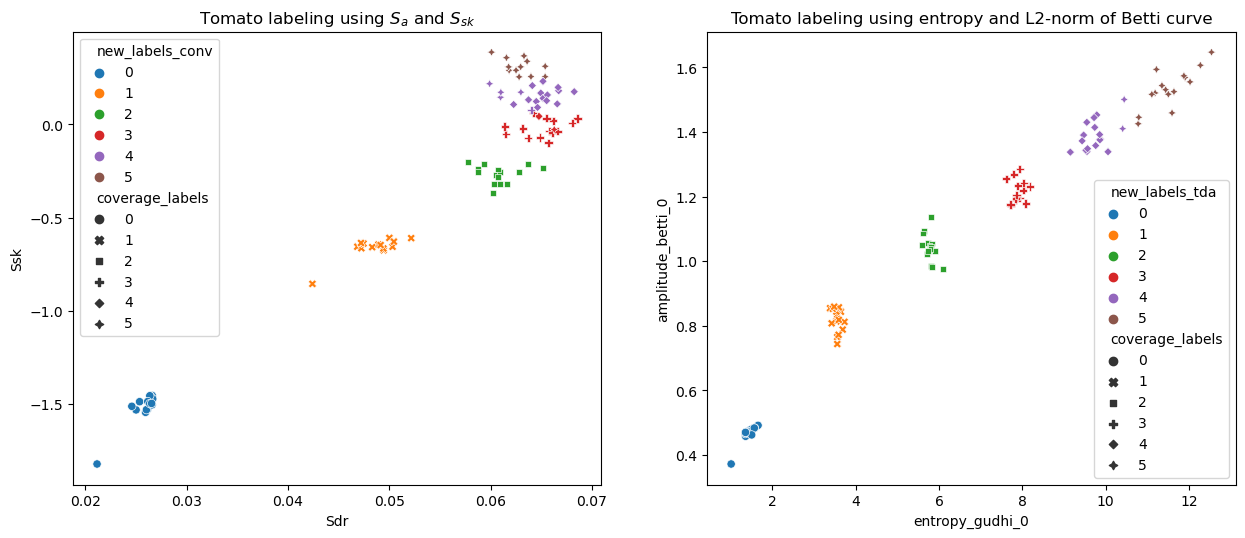

In [50]:
fig, ax = plt.subplots(1,2, dpi=100, figsize=(15,6))
axi = (0)
sns.scatterplot(data=df_plot,
                y=col_pair[1], 
                x=col_pair[0],
                hue='new_labels_conv', 
                palette='tab10',
                style='coverage_labels',
                ax=ax[axi])
ax[axi].set_title('Tomato labeling using $S_a$ and $S_{sk}$');

axi = (1)
sns.scatterplot(data=df_plot,
                y=col_pair_tda[1], 
                x=col_pair_tda[0],
                hue='new_labels_tda', 
                palette='tab10',
                style='coverage_labels',
                ax=ax[axi])
ax[axi].set_title('Tomato labeling using entropy and L2-norm of Betti curve');

Conv, number of misslabelled samples: 7
TDA, number of misslabelled samples: 2


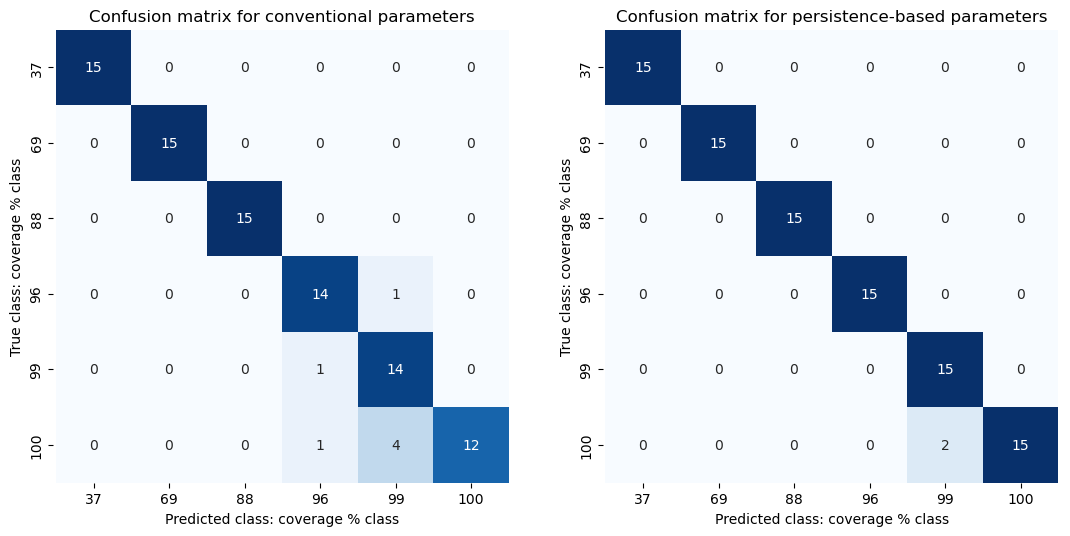

In [51]:

fig, ax = plt.subplots(1,2, dpi=100, figsize=(13,6))
axi = (0)
cf_matrix = confusion_matrix(le.inverse_transform(df_plot['coverage_labels']),
                             le.inverse_transform(df_plot['new_labels_conv']))
print('Conv, number of misslabelled samples:', 
      np.sum(np.abs(np.triu(cf_matrix) - np.tril(cf_matrix))))

sns.heatmap(cf_matrix,#/np.sum(cf_matrix), 
            annot=True,
            # fmt='.2%', 
            cmap='Blues',
            ax=ax[axi],
            xticklabels=np.unique(df_params['coverage']),
            yticklabels=np.unique(df_params['coverage']),
            cbar=False)
ax[axi].set_title('Confusion matrix for conventional parameters')
ax[axi].axis('equal')
ax[axi].set_ylabel('True class: coverage %'+' class')
ax[axi].set_xlabel('Predicted class: coverage %'+' class')

axi = (1)
cf_matrix = confusion_matrix(le.inverse_transform(df_plot['coverage_labels']),
                             le.inverse_transform(df_plot['new_labels_tda']))
print('TDA, number of misslabelled samples:', 
      np.sum(np.abs(np.triu(cf_matrix) - np.tril(cf_matrix))))

sns.heatmap(cf_matrix,#/np.sum(cf_matrix), 
            annot=True,
            # fmt='.2%', 
            cmap='Blues',
            ax=ax[axi],
            xticklabels=np.unique(df_params['coverage']),
            yticklabels=np.unique(df_params['coverage']),
            cbar=False)
ax[axi].set_title('Confusion matrix for persistence-based parameters')
ax[axi].axis('equal')
ax[axi].set_ylabel('True class: coverage %'+' class')
ax[axi].set_xlabel('Predicted class: coverage %'+' class')

savefig_severalformats(fig, f'tomato_gudhi_confusionmatrix_{file_appendix}',
                       figures_path)